# Method and Result 

Using an appropriately tuned deep feedforward neural network to train the data ($2000$ training examples, with each example consisting of a time series/trajectory for the $x$-coordinate of 102 steps), we found that accuracy on the test data ($1000$ test examples, with each example consisting of a trajectory for the $x$-coordinate of 102 steps) is around $93 \%$ (a significant improvement over the accuracy of a random baseline). The accuracy rate could be further improved by using, for instance, more training data, including the trajectory for the $y$-coordinate in the training data set, or a more sophisticated neural network architecture. 

In [6]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [7]:
# First, we get the data
dataset0 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m0.csv",header=None)
dataset1 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m1.csv",header=None)
dataset2 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m2.csv",header=None)

li = []
li.append(dataset0)
li.append(dataset1)
li.append(dataset2)

dataset = np.array(pd.concat(li, axis=0, ignore_index=True))
np.random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

np.savetxt('all_traj.csv', np.c_[dataset], delimiter=',') 

dataset.head(10)
row=np.shape(dataset)[0]
col=np.shape(dataset)[1]
print(row); print(col)

3000
102


In [8]:
# Checking for missing values
num_train = int(row*2/3)
training_set = dataset[:num_train].iloc[:,0:col].values
test_set = dataset[num_train:].iloc[:,0:col].values
print(np.shape(training_set)); print(np.shape(test_set))

(2000, 102)
(1000, 102)


In [9]:
training_df = pd.DataFrame(training_set)
training_df.head(10)

#pd.plotting.scatter_matrix(training_df, c=training_set['750'], figsize=(15,15), marker='o', s=60)
#plt.show()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.0,0.005917,-0.014919,-0.025271,-0.054580,-0.047405,-0.036849,-0.045826,-0.070926,-0.058524,...,-0.456992,-0.455515,-0.475321,-0.495757,-0.470785,-0.501330,-0.519588,-0.511101,-0.523270,1.0
1,0.0,0.010122,0.026897,0.001341,0.026228,0.031618,0.032011,-0.009722,-0.016024,-0.027293,...,0.136431,0.131556,0.120954,0.121202,0.120716,0.108841,0.097936,0.110991,0.115918,0.0
2,0.0,-0.014335,-0.004937,0.012488,0.021524,0.043106,0.027564,0.026114,0.032234,0.011147,...,0.103494,0.077861,0.051864,0.039734,0.044114,0.020761,-0.007039,-0.028365,-0.057913,2.0
3,0.0,-0.012685,-0.021520,-0.029870,-0.017310,-0.023700,-0.027145,-0.042304,-0.056873,-0.049443,...,-0.056277,-0.047090,-0.030296,-0.038074,-0.043922,-0.051046,-0.054153,-0.028927,-0.015559,0.0
4,0.0,0.002505,0.010167,-0.012033,-0.007883,-0.006042,-0.025921,-0.025726,-0.034747,-0.028961,...,-0.236607,-0.245837,-0.231785,-0.234614,-0.229503,-0.227589,-0.230369,-0.239519,-0.215754,0.0
5,0.0,0.012921,0.019048,0.036221,0.034004,0.014015,0.005883,0.006194,0.001293,-0.012036,...,-0.451704,-0.450624,-0.450703,-0.464482,-0.460956,-0.481136,-0.486432,-0.504481,-0.486251,1.0
6,0.0,0.000535,0.003537,0.023761,0.029217,0.046976,0.038772,0.032941,0.011174,-0.005505,...,-0.027107,-0.011182,0.002101,0.007328,0.020003,0.034761,0.026486,0.013341,-0.005342,0.0
7,0.0,0.012640,0.038045,0.009576,0.007516,-0.000270,-0.005328,0.002933,0.009642,0.000144,...,0.919888,0.927188,0.958612,0.947647,0.996720,1.023411,1.033983,1.049808,1.053242,2.0
8,0.0,-0.001153,-0.013394,0.006030,0.012625,0.018496,0.011931,0.024891,0.029608,0.052734,...,0.207476,0.202096,0.205030,0.203118,0.216371,0.236962,0.219202,0.215428,0.233862,0.0
9,0.0,-0.020120,-0.007772,-0.014959,-0.031024,-0.024136,-0.005736,-0.035497,-0.048936,-0.058170,...,-0.474206,-0.490314,-0.512202,-0.506013,-0.503897,-0.526692,-0.540602,-0.555435,-0.556029,1.0


In [10]:
from __future__ import print_function

import keras
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

#hyperparameters
batch_size = 500
epochs = 800

#number of categories
num_classes = 3

# the data, split between train and test sets
x_train=training_set[:,:col-1]
y_train=training_set[:,col-1:]
x_test=test_set[:,:col-1]
y_test=test_set[:,col-1:]

x_train = x_train.reshape(num_train, col-1)
x_test = x_test.reshape(row-num_train, col-1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(np.shape(x_train)); print(np.shape(x_test))
print(np.shape(y_train)); print(np.shape(y_test))

2000 train samples
1000 test samples
(2000, 101)
(1000, 101)
(2000, 1)
(1000, 1)


In [11]:
#accuracy of a random baseline
import copy
y_test_copy=copy.copy(y_test)
np.random.shuffle(y_test_copy)
float(np.sum(np.array(y_test)==np.array(y_test_copy)))/len(y_test)

0.329

In [12]:
# convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(64*2, activation='sigmoid', input_shape=(col-1,)))
model.add(Dropout(0.25))
model.add(Dense(64*2, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               13056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 29,955
Trainable params: 29,955
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 1000 samples
Epoch 1/800
2000/2000 [==============================] - 2s 759us/step - loss: 1.1532 - ac

Epoch 53/800
2000/2000 [==============================] - 0s 36us/step - loss: 0.5258 - acc: 0.7775 - val_loss: 0.4734 - val_acc: 0.8480
Epoch 54/800
2000/2000 [==============================] - 0s 47us/step - loss: 0.5150 - acc: 0.8015 - val_loss: 0.4717 - val_acc: 0.8580
Epoch 55/800
2000/2000 [==============================] - 0s 43us/step - loss: 0.5101 - acc: 0.8045 - val_loss: 0.4652 - val_acc: 0.8470
Epoch 56/800
2000/2000 [==============================] - 0s 80us/step - loss: 0.5103 - acc: 0.8025 - val_loss: 0.4638 - val_acc: 0.8400
Epoch 57/800
2000/2000 [==============================] - 0s 94us/step - loss: 0.5093 - acc: 0.8030 - val_loss: 0.4596 - val_acc: 0.8460
Epoch 58/800
2000/2000 [==============================] - 0s 66us/step - loss: 0.5102 - acc: 0.7970 - val_loss: 0.4674 - val_acc: 0.8720
Epoch 59/800
2000/2000 [==============================] - 0s 71us/step - loss: 0.5069 - acc: 0.8015 - val_loss: 0.4544 - val_acc: 0.8470
Epoch 60/800
2000/2000 [=================

2000/2000 [==============================] - 0s 41us/step - loss: 0.3663 - acc: 0.8630 - val_loss: 0.3390 - val_acc: 0.8780
Epoch 113/800
2000/2000 [==============================] - 0s 71us/step - loss: 0.3642 - acc: 0.8775 - val_loss: 0.3395 - val_acc: 0.8770
Epoch 114/800
2000/2000 [==============================] - 0s 46us/step - loss: 0.3668 - acc: 0.8655 - val_loss: 0.3460 - val_acc: 0.8700
Epoch 115/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.3662 - acc: 0.8700 - val_loss: 0.3375 - val_acc: 0.8730
Epoch 116/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.3548 - acc: 0.8720 - val_loss: 0.3355 - val_acc: 0.8840
Epoch 117/800
2000/2000 [==============================] - 0s 36us/step - loss: 0.3583 - acc: 0.8685 - val_loss: 0.3338 - val_acc: 0.8790
Epoch 118/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.3544 - acc: 0.8690 - val_loss: 0.3329 - val_acc: 0.8790
Epoch 119/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 30us/step - loss: 0.3319 - acc: 0.8795 - val_loss: 0.3033 - val_acc: 0.8950
Epoch 172/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.3181 - acc: 0.8860 - val_loss: 0.3075 - val_acc: 0.8850
Epoch 173/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.3324 - acc: 0.8820 - val_loss: 0.3019 - val_acc: 0.8930
Epoch 174/800
2000/2000 [==============================] - 0s 48us/step - loss: 0.3268 - acc: 0.8780 - val_loss: 0.3027 - val_acc: 0.8930
Epoch 175/800
2000/2000 [==============================] - 0s 39us/step - loss: 0.3251 - acc: 0.8820 - val_loss: 0.3016 - val_acc: 0.8980
Epoch 176/800
2000/2000 [==============================] - 0s 63us/step - loss: 0.3197 - acc: 0.8850 - val_loss: 0.3021 - val_acc: 0.8900
Epoch 177/800
2000/2000 [==============================] - 0s 52us/step - loss: 0.3171 - acc: 0.8815 - val_loss: 0.3016 - val_acc: 0.8970
Epoch 178/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 24us/step - loss: 0.2974 - acc: 0.8910 - val_loss: 0.2894 - val_acc: 0.8960
Epoch 231/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.2979 - acc: 0.8895 - val_loss: 0.2902 - val_acc: 0.8950
Epoch 232/800
2000/2000 [==============================] - 0s 23us/step - loss: 0.3018 - acc: 0.8925 - val_loss: 0.2871 - val_acc: 0.9020
Epoch 233/800
2000/2000 [==============================] - 0s 22us/step - loss: 0.2999 - acc: 0.8890 - val_loss: 0.2864 - val_acc: 0.8990
Epoch 234/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.2979 - acc: 0.8915 - val_loss: 0.2880 - val_acc: 0.8980
Epoch 235/800
2000/2000 [==============================] - 0s 36us/step - loss: 0.3038 - acc: 0.8940 - val_loss: 0.2876 - val_acc: 0.8970
Epoch 236/800
2000/2000 [==============================] - 0s 37us/step - loss: 0.2966 - acc: 0.8940 - val_loss: 0.2887 - val_acc: 0.8970
Epoch 237/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 27us/step - loss: 0.2831 - acc: 0.9040 - val_loss: 0.2782 - val_acc: 0.9080
Epoch 290/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.2907 - acc: 0.8945 - val_loss: 0.2784 - val_acc: 0.9000
Epoch 291/800
2000/2000 [==============================] - 0s 27us/step - loss: 0.2890 - acc: 0.8940 - val_loss: 0.2764 - val_acc: 0.9030
Epoch 292/800
2000/2000 [==============================] - 0s 23us/step - loss: 0.2909 - acc: 0.8980 - val_loss: 0.2770 - val_acc: 0.9010
Epoch 293/800
2000/2000 [==============================] - 0s 51us/step - loss: 0.2883 - acc: 0.8915 - val_loss: 0.2779 - val_acc: 0.8990
Epoch 294/800
2000/2000 [==============================] - 0s 49us/step - loss: 0.2865 - acc: 0.8965 - val_loss: 0.2763 - val_acc: 0.9030
Epoch 295/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.2890 - acc: 0.8900 - val_loss: 0.2757 - val_acc: 0.9050
Epoch 296/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 37us/step - loss: 0.2761 - acc: 0.9020 - val_loss: 0.2692 - val_acc: 0.9100
Epoch 349/800
2000/2000 [==============================] - 0s 43us/step - loss: 0.2748 - acc: 0.8995 - val_loss: 0.2694 - val_acc: 0.9070
Epoch 350/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.2787 - acc: 0.8965 - val_loss: 0.2694 - val_acc: 0.9080
Epoch 351/800
2000/2000 [==============================] - 0s 34us/step - loss: 0.2732 - acc: 0.8980 - val_loss: 0.2687 - val_acc: 0.9100
Epoch 352/800
2000/2000 [==============================] - 0s 26us/step - loss: 0.2747 - acc: 0.8985 - val_loss: 0.2692 - val_acc: 0.9090
Epoch 353/800
2000/2000 [==============================] - 0s 26us/step - loss: 0.2713 - acc: 0.9010 - val_loss: 0.2691 - val_acc: 0.9100
Epoch 354/800
2000/2000 [==============================] - 0s 38us/step - loss: 0.2665 - acc: 0.9005 - val_loss: 0.2714 - val_acc: 0.9050
Epoch 355/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 33us/step - loss: 0.2684 - acc: 0.9055 - val_loss: 0.2637 - val_acc: 0.9050
Epoch 408/800
2000/2000 [==============================] - 0s 35us/step - loss: 0.2691 - acc: 0.8995 - val_loss: 0.2629 - val_acc: 0.9080
Epoch 409/800
2000/2000 [==============================] - 0s 27us/step - loss: 0.2684 - acc: 0.8965 - val_loss: 0.2620 - val_acc: 0.9110
Epoch 410/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.2622 - acc: 0.9025 - val_loss: 0.2631 - val_acc: 0.9100
Epoch 411/800
2000/2000 [==============================] - 0s 26us/step - loss: 0.2644 - acc: 0.9070 - val_loss: 0.2631 - val_acc: 0.9050
Epoch 412/800
2000/2000 [==============================] - 0s 36us/step - loss: 0.2701 - acc: 0.9010 - val_loss: 0.2616 - val_acc: 0.9100
Epoch 413/800
2000/2000 [==============================] - 0s 37us/step - loss: 0.2656 - acc: 0.9050 - val_loss: 0.2623 - val_acc: 0.9080
Epoch 414/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 57us/step - loss: 0.2537 - acc: 0.9055 - val_loss: 0.2526 - val_acc: 0.9130
Epoch 467/800
2000/2000 [==============================] - 0s 38us/step - loss: 0.2573 - acc: 0.9080 - val_loss: 0.2542 - val_acc: 0.9120
Epoch 468/800
2000/2000 [==============================] - 0s 39us/step - loss: 0.2633 - acc: 0.9045 - val_loss: 0.2526 - val_acc: 0.9130
Epoch 469/800
2000/2000 [==============================] - 0s 24us/step - loss: 0.2567 - acc: 0.9115 - val_loss: 0.2519 - val_acc: 0.9150
Epoch 470/800
2000/2000 [==============================] - 0s 26us/step - loss: 0.2502 - acc: 0.9115 - val_loss: 0.2522 - val_acc: 0.9140
Epoch 471/800
2000/2000 [==============================] - 0s 44us/step - loss: 0.2668 - acc: 0.9100 - val_loss: 0.2537 - val_acc: 0.9120
Epoch 472/800
2000/2000 [==============================] - 0s 42us/step - loss: 0.2538 - acc: 0.9080 - val_loss: 0.2522 - val_acc: 0.9120
Epoch 473/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 27us/step - loss: 0.2561 - acc: 0.9055 - val_loss: 0.2442 - val_acc: 0.9170
Epoch 526/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.2483 - acc: 0.9080 - val_loss: 0.2431 - val_acc: 0.9180
Epoch 527/800
2000/2000 [==============================] - 0s 33us/step - loss: 0.2593 - acc: 0.9065 - val_loss: 0.2426 - val_acc: 0.9190
Epoch 528/800
2000/2000 [==============================] - 0s 35us/step - loss: 0.2573 - acc: 0.9030 - val_loss: 0.2433 - val_acc: 0.9170
Epoch 529/800
2000/2000 [==============================] - 0s 36us/step - loss: 0.2508 - acc: 0.9075 - val_loss: 0.2425 - val_acc: 0.9190
Epoch 530/800
2000/2000 [==============================] - 0s 47us/step - loss: 0.2595 - acc: 0.9035 - val_loss: 0.2426 - val_acc: 0.9190
Epoch 531/800
2000/2000 [==============================] - 0s 37us/step - loss: 0.2445 - acc: 0.9135 - val_loss: 0.2434 - val_acc: 0.9170
Epoch 532/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 21us/step - loss: 0.2402 - acc: 0.9130 - val_loss: 0.2361 - val_acc: 0.9230
Epoch 585/800
2000/2000 [==============================] - 0s 26us/step - loss: 0.2433 - acc: 0.9115 - val_loss: 0.2365 - val_acc: 0.9210
Epoch 586/800
2000/2000 [==============================] - 0s 22us/step - loss: 0.2435 - acc: 0.9110 - val_loss: 0.2356 - val_acc: 0.9230
Epoch 587/800
2000/2000 [==============================] - 0s 19us/step - loss: 0.2369 - acc: 0.9180 - val_loss: 0.2390 - val_acc: 0.9200
Epoch 588/800
2000/2000 [==============================] - 0s 21us/step - loss: 0.2446 - acc: 0.9085 - val_loss: 0.2360 - val_acc: 0.9200
Epoch 589/800
2000/2000 [==============================] - 0s 22us/step - loss: 0.2405 - acc: 0.9080 - val_loss: 0.2349 - val_acc: 0.9240
Epoch 590/800
2000/2000 [==============================] - 0s 22us/step - loss: 0.2418 - acc: 0.9120 - val_loss: 0.2352 - val_acc: 0.9210
Epoch 591/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 20us/step - loss: 0.2334 - acc: 0.9160 - val_loss: 0.2312 - val_acc: 0.9260
Epoch 644/800
2000/2000 [==============================] - 0s 18us/step - loss: 0.2330 - acc: 0.9155 - val_loss: 0.2316 - val_acc: 0.9250
Epoch 645/800
2000/2000 [==============================] - 0s 24us/step - loss: 0.2363 - acc: 0.9140 - val_loss: 0.2311 - val_acc: 0.9260
Epoch 646/800
2000/2000 [==============================] - 0s 21us/step - loss: 0.2385 - acc: 0.9080 - val_loss: 0.2302 - val_acc: 0.9250
Epoch 647/800
2000/2000 [==============================] - 0s 18us/step - loss: 0.2347 - acc: 0.9130 - val_loss: 0.2305 - val_acc: 0.9250
Epoch 648/800
2000/2000 [==============================] - 0s 18us/step - loss: 0.2405 - acc: 0.9155 - val_loss: 0.2307 - val_acc: 0.9290
Epoch 649/800
2000/2000 [==============================] - 0s 27us/step - loss: 0.2324 - acc: 0.9150 - val_loss: 0.2310 - val_acc: 0.9200
Epoch 650/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 22us/step - loss: 0.2396 - acc: 0.9090 - val_loss: 0.2268 - val_acc: 0.9280
Epoch 703/800
2000/2000 [==============================] - 0s 19us/step - loss: 0.2326 - acc: 0.9205 - val_loss: 0.2277 - val_acc: 0.9290
Epoch 704/800
2000/2000 [==============================] - 0s 24us/step - loss: 0.2277 - acc: 0.9140 - val_loss: 0.2264 - val_acc: 0.9300
Epoch 705/800
2000/2000 [==============================] - 0s 24us/step - loss: 0.2347 - acc: 0.9125 - val_loss: 0.2262 - val_acc: 0.9310
Epoch 706/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.2314 - acc: 0.9160 - val_loss: 0.2256 - val_acc: 0.9290
Epoch 707/800
2000/2000 [==============================] - 0s 23us/step - loss: 0.2296 - acc: 0.9165 - val_loss: 0.2265 - val_acc: 0.9290
Epoch 708/800
2000/2000 [==============================] - 0s 19us/step - loss: 0.2352 - acc: 0.9155 - val_loss: 0.2257 - val_acc: 0.9290
Epoch 709/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 19us/step - loss: 0.2347 - acc: 0.9150 - val_loss: 0.2235 - val_acc: 0.9290
Epoch 762/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.2395 - acc: 0.9090 - val_loss: 0.2237 - val_acc: 0.9280
Epoch 763/800
2000/2000 [==============================] - 0s 24us/step - loss: 0.2291 - acc: 0.9195 - val_loss: 0.2239 - val_acc: 0.9270
Epoch 764/800
2000/2000 [==============================] - 0s 25us/step - loss: 0.2253 - acc: 0.9190 - val_loss: 0.2232 - val_acc: 0.9280
Epoch 765/800
2000/2000 [==============================] - 0s 36us/step - loss: 0.2259 - acc: 0.9205 - val_loss: 0.2248 - val_acc: 0.9260
Epoch 766/800
2000/2000 [==============================] - 0s 26us/step - loss: 0.2311 - acc: 0.9155 - val_loss: 0.2233 - val_acc: 0.9270
Epoch 767/800
2000/2000 [==============================] - 0s 24us/step - loss: 0.2216 - acc: 0.9195 - val_loss: 0.2237 - val_acc: 0.9280
Epoch 768/800
2000/2000 [=======================

In [14]:
classes = model.predict(x_test)
print(classes)
print(np.shape(classes)) #probability distribution for each of the 3 models

[[1.9538568e-06 9.6769160e-01 3.2306381e-02]
 [1.8085571e-03 8.5312420e-01 1.4506727e-01]
 [8.8720995e-01 5.2870415e-05 1.1273716e-01]
 ...
 [3.4390837e-08 9.5405078e-01 4.5949236e-02]
 [1.7025011e-06 9.2704749e-01 7.2950810e-02]
 [9.5771277e-01 3.4587254e-05 4.2252637e-02]]
(1000, 3)


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


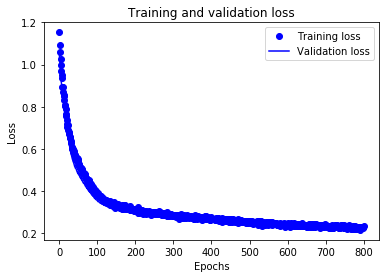

In [15]:
history_dict = history.history
print(history_dict.keys())
#plotting the training and validation loss
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss') #bo for blue dot
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

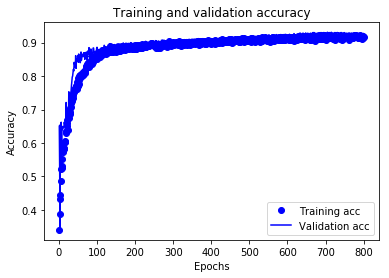

In [16]:
plt.clf()
acc=history_dict['acc']
val_acc=history_dict['val_acc']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
#model.save('traj_class_ffnn.h5')